## 2020707035 박시언 lab3
1. 데이터를 분석합니다.
2. 데이터를 9개의 구간으로 나눠서 "로그1p변환"의 값으로 평균, 분산, 표준편자 등등 통계 데이터를 활용하여 feature를 만들어냅니다.
3. 8번은 pass에 대해서는 데이터 증강을 진행하지 않습니다. 나머지 케이스는 데이터를 증강합니다.
4. ADASYN으로 2차 증강을 진행합니다.
5. 증강 안하고 fitering만 한 데이터와, augmentation을 진행한 데이터, augmentation & adasyn 까지 적용한 데이터 각각 성능 평가를 진행합니다.
6. 베이지안 최적화 모듈을 통해서 최적의 파라미터를 구하고 해당 모델을 다시 평가합니다.
7. 최종 벨런스스코어는 0.72가 나옵니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, rotate, shift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
df = pd.read_pickle("/home/unsi/다운로드/LSWMD.pkl")  #우분투 -> /home/unsi/다운로드/LSWMD.pkl || 맥 -> /Users/unsi/Downloads/LSWMD.pkl

In [3]:
df.iloc[35]['failureType']

array([], shape=(0, 0), dtype=float64)

In [4]:
# 빈 리스트를 포함하는 행만 필터링하기
passed = df[df['failureType'].apply(lambda x: x.shape == (0, 0) or x[0][0] == 'none')]
passed['failureType'] = 8
eda_pass = passed
passed = passed.sample(n=100000, random_state=42)

/tmp/ipykernel_12356/2072027894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed['failureType'] = 8


In [5]:
# Filtering rows based on a nested condition in the 'failureType' column
faild = df[df['failureType'].apply(lambda x: len(x) > 0 and len(x[0]) > 0 and x[0][0] != 'none')]
faild

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]]
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]]
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]]
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]]
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]]
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]]
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]]
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]


In [6]:
faild.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

In [7]:
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'pass': 8
}

#failureType 인코딩 
faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))

# 결과 확인
faild


/tmp/ipykernel_12356/1474913133.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],3
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],1


In [8]:
df = pd.concat([faild, passed])
df


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [9]:
eda_df = pd.concat([faild, eda_pass])

# EDA
1. pass fail 분포를 확인합니다. 각각의 클래스 또한 확인합니다.
2. 웨이퍼 맵에 어느 부분에 불량 다이가 분포했는지 확인합니다. (웨이퍼맵을 9개로 등분하여 각각 0,1,2,3,4,5,6,7,8,9 의 구간으로 나눕니다.)

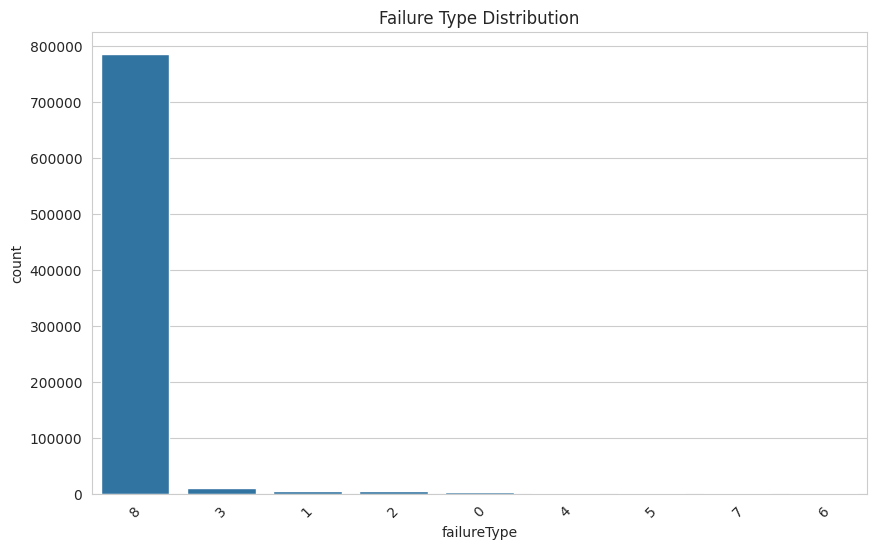

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 pass/fail 분포 확인
eda_df['pass_fail'] = eda_df['failureType'].apply(lambda x: 'pass' if x == 'None' else 'fail')


# 클래스별 분포 확인 (None은 제외하고 나머지 분포)
plt.figure(figsize=(10, 6))
sns.countplot(x='failureType', data=eda_df[eda_df['failureType'] != 'None'], order=eda_df['failureType'].value_counts().index)
plt.title('Failure Type Distribution')
plt.xticks(rotation=45)
plt.show()


Average occurrences of value 2 for each section: [ 8.59986427 12.33676421  8.48929535 12.65850151 10.73069528 13.18520254
  9.35990241 12.5659164   8.8014833 ]


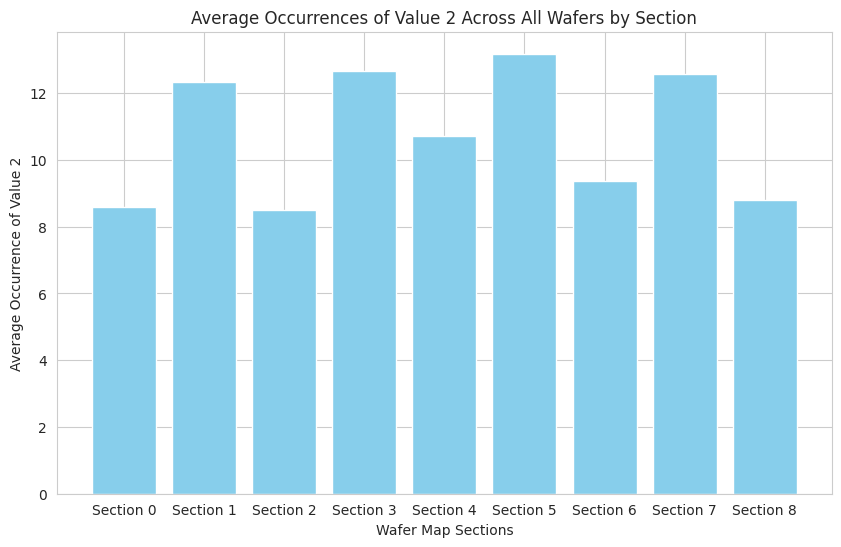

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 웨이퍼 맵을 9개의 구간으로 나누는 함수
def divide_wafer_map(wafer_map, grid_size=(3, 3)):
    rows, cols = wafer_map.shape
    row_step, col_step = rows // grid_size[0], cols // grid_size[1]
    
    divided_map = []
    for i in range(0, rows, row_step):
        for j in range(0, cols, col_step):
            section = wafer_map[i:i + row_step, j:j + col_step]
            divided_map.append(section)
    
    if len(divided_map) == 9:
        return divided_map
    else:
        return None

# 각 웨이퍼 맵의 구간에서 값 2가 나타난 빈도를 계산하는 함수
def calculate_occurrences_of_value(wafer_map, target_value=2):
    sections = divide_wafer_map(wafer_map)
    if sections is None:
        return None
    
    occurrence_counts = []
    for section in sections:
        count_value = np.sum(section == target_value)  # 해당 값(2)이 나타난 빈도 계산
        occurrence_counts.append(count_value)
    
    return occurrence_counts

# 모든 웨이퍼 맵에 대해 구간별로 2가 나타난 빈도의 평균을 계산
total_occurrences = np.zeros(9)  # 각 구간에서 2가 나타난 빈도 합계 저장
num_wafer_maps = 0  # 분석된 웨이퍼 맵 개수

for i, row in eda_df.iterrows():
    if isinstance(row['waferMap'], np.ndarray):
        occurrences = calculate_occurrences_of_value(row['waferMap'], target_value=2)
        if occurrences is not None:  # 유효한 구간 나누기가 된 경우만 처리
            total_occurrences += occurrences  # 각 구간에서 2가 나타난 빈도 합산
            num_wafer_maps += 1

# 전체 웨이퍼에 대한 각 구간에서 2가 나타난 평균 빈도 계산
if num_wafer_maps > 0:
    average_occurrences = total_occurrences / num_wafer_maps
    print(f'Average occurrences of value 2 for each section: {average_occurrences}')
else:
    print("No valid wafer maps were found.")

# 구간별 평균 2의 빈도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(9), average_occurrences, color='skyblue')
plt.title('Average Occurrences of Value 2 Across All Wafers by Section')
plt.xlabel('Wafer Map Sections')
plt.ylabel('Average Occurrence of Value 2')
plt.xticks(range(9), labels=[f'Section {i}' for i in range(9)])
plt.show()


In [12]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


encoder = OneHotEncoder(sparse_output=False)
encoded_failure_type = encoder.fit_transform(df[['failureType']])
encoded_df = pd.DataFrame(encoded_failure_type, columns=encoder.get_feature_names_out(['failureType']))
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)


In [13]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureType_0,failureType_1,failureType_2,failureType_3,failureType_4,failureType_5,failureType_6,failureType_7,failureType_8
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
from sklearn.model_selection import train_test_split
train_df,test_df,_,__ = train_test_split(df,np.random.randn(len(df)), test_size=0.2, random_state=42,stratify=df['failureType'])

In [15]:
train_df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureType_0,failureType_1,failureType_2,failureType_3,failureType_4,failureType_5,failureType_6,failureType_7,failureType_8
68385,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot11503,14.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67315,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3701.0,lot25468,3.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17181,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot40415,6.0,[[Test]],2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
83408,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,...",515.0,lot32340,12.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43432,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2570.0,lot19274,15.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84247,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",924.0,lot2118,1.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118506,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot27778,8.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87937,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36104,3.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84895,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5085.0,lot11486,2.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
test_df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureType_0,failureType_1,failureType_2,failureType_3,failureType_4,failureType_5,failureType_6,failureType_7,failureType_8
58093,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4169.0,lot13597,8.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
91583,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot27293,3.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21365,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1421.0,lot44797,4.0,[[Test]],3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
77362,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20175,7.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31218,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot4914,4.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54191,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot31830,14.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32245,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",592.0,lot42083,15.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot28593,23.0,[],8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13330,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot23648,10.0,[[Training]],0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
import numpy as np
import pandas as pd


def augment_wafer_map(wafer_map):
    # 좌우 뒤집기
    flipped_lr = np.fliplr(wafer_map)

    # 상하 뒤집기
    flipped_ud = np.flipud(wafer_map)

    # 90도 회전 (시계 방향)
    rotated_90 = np.rot90(wafer_map, k=-1)

    # 180도 회전
    rotated_180 = np.rot90(wafer_map, k=2)

    # 270도 회전 (반시계 방향)
    rotated_270 = np.rot90(wafer_map, k=1)

    return [wafer_map, flipped_lr, flipped_ud, rotated_90, rotated_180, rotated_270]


def augment_dataframe(df):
    augmented_data = []

    for _, row in df.iterrows():
        wafer_map = row['waferMap']
        die_size = row['dieSize']
        lot_name = row['lotName']
        wafer_index = row['waferIndex']
        train_test_label = row['trianTestLabel']
        failure_type = row['failureType']
        
        # failure_type이 8이 아닐 경우에만 증강
        if failure_type != 8:
            augmented_wafer_maps = augment_wafer_map(wafer_map)
            for augmented_map in augmented_wafer_maps:
                augmented_data.append({
                    'waferMap': augmented_map,
                    'dieSize': die_size,
                    'lotName': lot_name,
                    'waferIndex': wafer_index,
                    'trianTestLabel': train_test_label,
                    'failureType': failure_type
                })
        # failure_type이 8인 경우 원본 행을 추가
        augmented_data.append(row.to_dict())

    # 증강된 데이터로 새로운 DataFrame 생성
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

print("Original DataFrame shape:", train_df.shape)
train_df_aug = augment_dataframe(train_df)
print("Augmented DataFrame shape:", train_df_aug.shape)


Original DataFrame shape: (100415, 15)
Augmented DataFrame shape: (222905, 15)


In [18]:
train_df_aug['failureType'].value_counts()

failureType
8    80000
3    54208
1    29057
2    24045
0    20118
4     6685
5     4851
7     3108
6      833
Name: count, dtype: int64

In [19]:
train_df['failureType'].value_counts()

failureType
8    80000
3     7744
1     4151
2     3435
0     2874
4      955
5      693
7      444
6      119
Name: count, dtype: int64

In [20]:
def apply_median_filter(wafer_map, size=3):
    return median_filter(wafer_map, size=size)

# DataFrame에 있는 모든 WaferMap에 미디언 필터 적용
train_df['waferMap'] = train_df['waferMap'].apply(lambda x: apply_median_filter(x, size=3))
train_df_aug['waferMap']= train_df_aug['waferMap'].apply(lambda x: apply_median_filter(x, size=3))
test_df['waferMap'] = test_df['waferMap'].apply(lambda x: apply_median_filter(x, size=3))

In [21]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count

# 최대 패딩 크기를 정의
target_height, target_width = 60, 60

# 각 웨이퍼 맵에 패딩을 추가하고 로그 변환을 적용하는 함수
def pad_and_log_transform(wafer_map):
    current_height, current_width = wafer_map.shape
    
    # 필요한 패딩 계산
    pad_height = max(0, target_height - current_height)
    pad_width = max(0, target_width - current_width)
    
    # 패딩을 추가하여 60x60 크기의 배열 생성
    padded_wafer_map = np.pad(
        wafer_map,
        ((0, pad_height), (0, pad_width)),
        mode='constant',
        constant_values=0
    )
    
    # 로그 변환 적용
    #log_transformed_wafer_map = np.log1p(padded_wafer_map)
    
    return padded_wafer_map

# 병렬 처리를 위한 함수
def parallel_apply(df, column):
    # 60x60 이하인 웨이퍼 맵만 필터링
    df_filtered = df[df[column].apply(lambda x: x.shape[0] <= target_height and x.shape[1] <= target_width)].copy()
    
    # 병렬 처리 수행
    with Pool(cpu_count()) as pool:
        transformed_maps = pool.map(pad_and_log_transform, df_filtered[column])
    
    # 필터링된 데이터프레임에 변환된 웨이퍼 맵 추가
    df_filtered['paddedWaferMap'] = transformed_maps
    return df_filtered

# 각 데이터프레임에 병렬 처리 적용하여 결과 저장
train_df_filtered = parallel_apply(train_df, 'waferMap')
train_df_aug_filtered = parallel_apply(train_df_aug, 'waferMap')
test_df_filtered = parallel_apply(test_df, 'waferMap')


In [22]:
train_df_filtered['paddedWaferMap'][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [23]:
train_df_filtered.iloc[:, -10:-1]

,failureType_0,failureType_1,failureType_2,failureType_3,failureType_4,failureType_5,failureType_6,failureType_7,failureType_8
68385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17181,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
83408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
81636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class WaferDataset(Dataset):
    def __init__(self, wafer_maps, labels):
        # 데이터셋 초기화 (wafer_maps: 웨이퍼 맵 열, labels: 원핫 인코딩된 레이블 열)
        self.wafer_maps = wafer_maps.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True) # 레이블을 float32로 변환

    def __len__(self):
        # 데이터셋 크기 반환
        return len(self.wafer_maps)

    def __getitem__(self, idx):
        # 웨이퍼 맵을 float32로 변환하여 텐서로 변환
        wafer_map = self.wafer_maps[idx]
        wafer_map_tensor = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0).to(torch.float32)
        
        # 레이블을 텐서로 변환
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)
        return wafer_map_tensor.to('cuda'), label.to('cuda')




wafer_maps_noaug = train_df_filtered['paddedWaferMap']
labels_noaug = train_df_filtered.iloc[:, -10:-1]
train_ds_nopaug = WaferDataset(wafer_maps_noaug, labels_noaug)
train_loader_noaug = DataLoader(train_ds_nopaug, batch_size=32, shuffle=True)


wafer_maps_aug = train_df_aug_filtered['paddedWaferMap']
labels_aug = train_df_aug_filtered.iloc[:, -10:-1]
train_ds_aug = WaferDataset(wafer_maps_aug, labels_aug)
train_loader_aug = DataLoader(train_ds_aug, batch_size=32, shuffle=True)


wafer_maps_test = test_df_filtered['paddedWaferMap']
labels_test = test_df_filtered.iloc[:, -10:-1]
test_ds = WaferDataset(wafer_maps_test, labels_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)



In [25]:
x,y = next(iter(train_loader_noaug))
print(x.shape)
print(y.shape)

torch.Size([32, 1, 60, 60])
torch.Size([32, 9])


In [42]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, inch = 1):
        super(MyModel, self).__init__()
        self.FeatureExtractor = nn.Sequential(
            nn.Conv2d(inch, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
        )
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Linear(64 * 6 * 6, 64*6),
            nn.ReLU(inplace=True),
            nn.Linear(64*6, 10),
        )
        
    def forward(self, x):
        x = self.FeatureExtractor(x)
        x = self.flatten(x)
        x = self.head(x)
        return x
    
model = MyModel()
tmp = torch.randn(4, 1, 60, 60)
(model(tmp))

tensor([[ 0.6425, -0.3924,  0.1418,  0.4034,  0.6241, -0.6443,  0.9232, -0.1999,
         -0.8983,  0.1123],
        [ 0.3280, -0.8511, -0.2899, -0.5247, -0.9134, -0.4210, -0.4381,  0.4081,
         -0.1001, -0.8064],
        [-0.1674,  0.0496, -0.6621, -0.4187, -0.5161, -0.3168,  0.3144, -0.1008,
          0.4282,  0.1302],
        [ 0.6388, -0.2945, -0.4116,  0.1061,  0.4482,  0.8685,  0.7498,  0.5323,
         -0.0900, -0.2916]], grad_fn=<AddmmBackward0>)

In [43]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import torch.optim as optim
epoch = 100


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


train_size = int(0.8 * len(train_ds_aug))
val_size = len(train_ds_aug) - train_size
train_ds, val_ds = random_split(train_ds_aug, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


model_no_aug = MyModel().cuda()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model_no_aug.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.001)


n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    model_no_aug.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()
        optimizer.zero_grad()
        outputs = model_no_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

 
    train_loss /= len(train_loader.dataset)


    model_no_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
            outputs = model_no_aug(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

   
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
        


  2%|▏         | 1/50 [00:15<12:32, 15.36s/it]

Epoch 1, Train Loss: 0.5188, Validation Loss: 0.4480


  4%|▍         | 2/50 [00:27<10:53, 13.61s/it]

Epoch 2, Train Loss: 0.4173, Validation Loss: 0.4367


  6%|▌         | 3/50 [00:40<10:21, 13.23s/it]

Epoch 3, Train Loss: 0.3886, Validation Loss: 0.4023


  8%|▊         | 4/50 [00:52<09:54, 12.92s/it]

Epoch 4, Train Loss: 0.3705, Validation Loss: 0.3855


 10%|█         | 5/50 [01:05<09:30, 12.68s/it]

Epoch 5, Train Loss: 0.3583, Validation Loss: 0.3928


 12%|█▏        | 6/50 [01:18<09:25, 12.86s/it]

Epoch 6, Train Loss: 0.3487, Validation Loss: 0.3795


 14%|█▍        | 7/50 [01:30<09:05, 12.68s/it]

Epoch 7, Train Loss: 0.3406, Validation Loss: 0.3815


 16%|█▌        | 8/50 [01:42<08:46, 12.53s/it]

Epoch 8, Train Loss: 0.3350, Validation Loss: 0.3705


 18%|█▊        | 9/50 [01:55<08:29, 12.42s/it]

Epoch 9, Train Loss: 0.3294, Validation Loss: 0.3867


 20%|██        | 10/50 [02:07<08:16, 12.41s/it]

Epoch 10, Train Loss: 0.3245, Validation Loss: 0.3713


 22%|██▏       | 11/50 [02:20<08:06, 12.48s/it]

Epoch 11, Train Loss: 0.3210, Validation Loss: 0.3724


 24%|██▍       | 12/50 [02:32<07:56, 12.54s/it]

Epoch 12, Train Loss: 0.3170, Validation Loss: 0.3730


 24%|██▍       | 12/50 [02:45<08:44, 13.81s/it]

Epoch 13, Train Loss: 0.3131, Validation Loss: 0.3736
Early stopping


In [45]:
train_size = int(0.8 * len(train_ds_aug))
val_size = len(train_ds_aug) - train_size
train_ds, val_ds = random_split(train_ds_aug, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

model_aug = MyModel().cuda()
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.001)

n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    model_aug.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
        optimizer.zero_grad()
        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)


    model_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
            outputs = model_aug(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

  2%|▏         | 1/50 [00:12<10:17, 12.60s/it]

Epoch 1, Train Loss: 0.5218, Validation Loss: 0.4597


  4%|▍         | 2/50 [00:25<10:25, 13.03s/it]

Epoch 2, Train Loss: 0.4152, Validation Loss: 0.4163


  6%|▌         | 3/50 [00:38<10:07, 12.93s/it]

Epoch 3, Train Loss: 0.3873, Validation Loss: 0.3875


  8%|▊         | 4/50 [00:51<09:45, 12.73s/it]

Epoch 4, Train Loss: 0.3710, Validation Loss: 0.3969


 10%|█         | 5/50 [01:03<09:25, 12.57s/it]

Epoch 5, Train Loss: 0.3582, Validation Loss: 0.3829


 12%|█▏        | 6/50 [01:15<09:07, 12.43s/it]

Epoch 6, Train Loss: 0.3486, Validation Loss: 0.3699


 14%|█▍        | 7/50 [01:27<08:50, 12.34s/it]

Epoch 7, Train Loss: 0.3417, Validation Loss: 0.3673


 16%|█▌        | 8/50 [01:39<08:35, 12.28s/it]

Epoch 8, Train Loss: 0.3354, Validation Loss: 0.3748


 18%|█▊        | 9/50 [01:52<08:21, 12.24s/it]

Epoch 9, Train Loss: 0.3304, Validation Loss: 0.3700


 20%|██        | 10/50 [02:04<08:08, 12.21s/it]

Epoch 10, Train Loss: 0.3261, Validation Loss: 0.3651


 22%|██▏       | 11/50 [02:16<07:55, 12.19s/it]

Epoch 11, Train Loss: 0.3219, Validation Loss: 0.3607


 24%|██▍       | 12/50 [02:28<07:42, 12.17s/it]

Epoch 12, Train Loss: 0.3170, Validation Loss: 0.3672


 26%|██▌       | 13/50 [02:41<07:37, 12.38s/it]

Epoch 13, Train Loss: 0.3143, Validation Loss: 0.3673


 28%|██▊       | 14/50 [02:53<07:22, 12.30s/it]

Epoch 14, Train Loss: 0.3112, Validation Loss: 0.3684


 30%|███       | 15/50 [03:06<07:13, 12.38s/it]

Epoch 15, Train Loss: 0.3086, Validation Loss: 0.3661


 30%|███       | 15/50 [03:18<07:43, 13.24s/it]

Epoch 16, Train Loss: 0.3056, Validation Loss: 0.3665
Early stopping


In [46]:
from sklearn.metrics import balanced_accuracy_score
import torch

# 테스트에서 balanced accuracy score를 계산하는 함수
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  # CUDA로 이동

            # 모델 예측
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 각 샘플의 예측 클래스

            # 예측값과 실제 레이블을 CPU로 이동하여 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # balanced accuracy score 계산
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f'Balanced Accuracy Score: {balanced_acc:.4f}')
    return balanced_acc




In [47]:
balanced_accuracy1 = evaluate_model(model_no_aug, test_loader)
balanced_accuracy2 = evaluate_model(model_aug, test_loader)

Balanced Accuracy Score: 0.3776
Balanced Accuracy Score: 0.3601
